In [2]:
import numpy as np
import pandas as pd
import re,os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

In [3]:
def voted_gene_list(gene_list,vote_number,threshold) :
    gene_l = np.array(gene_list)
    voted_idx =  vote_number > threshold
    return gene_l[voted_idx]

def pls_by_voted(non_hallmark_vote_result,hallmark_gene,exp_matrix,threshold) :

    voted_gene = voted_gene_list(non_hallmark_vote_result.index,non_hallmark_vote_result['Vote'].values,threshold)
    hallmark_m = exp_matrix.loc[hallmark_gene,:].T.to_numpy()
    voted_m = exp_matrix.loc[voted_gene,:].T.to_numpy()
    #calculated PLS, voted as training variable, hallmark exp as target variable
    x_train, x_test, y_train, y_test = train_test_split(voted_m,hallmark_m)
    pls = PLSRegression(n_components=2,scale=False,max_iter=2000)
    pls.fit(x_train, y_train)
    return pls.score(x_test, y_test)

def non_voted_random_cca(non_hallmark_vote_result,hallmark_gene,exp_matrix,threshold) :

    voted_gene = voted_gene_list(non_hallmark_vote_result.index,non_hallmark_vote_result['Vote'].values,threshold)
    hallmark_m = exp_matrix.loc[hallmark_gene,:].T.to_numpy()
    non_voted_gene = list(set(exp_matrix.index) - set(voted_gene) - set(hallmark_gene))
    target_non_voted_gene = random.sample(non_voted_gene,len(voted_gene))
    non_voted_m = exp_matrix.loc[target_non_voted_gene,:].T.to_numpy()
    #calculated CCA
    x_train, x_test, y_train, y_test = train_test_split(non_voted_m,hallmark_m)
    pls = PLSRegression(n_components=2,scale=False,max_iter=2000)
    pls.fit(x_train, y_train)
    return pls.score(x_test, y_test)

In [4]:
vote_result = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/vote_result/normal_only_std_by_gene_vote_np_ratio_15.txt',sep='\t',index_col=0)
coding_gene_idx = [bool(re.search('Synthetic',x)) == False for x in vote_result.index]# type: ignore    
coding_gene = vote_result.index[coding_gene_idx]
hallmark = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt',sep='\t')
hallmark_gene = hallmark['EnsID'].values
non_hallmark_gene = list(set(coding_gene) - set(hallmark_gene))

exp_profile = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_coding_gene_fpkm.txt',sep='\t',index_col=0)
scaler = StandardScaler()
std_x = scaler.fit_transform(exp_profile.T.to_numpy())
exp_m = pd.DataFrame(std_x.T,index=exp_profile.index,columns=exp_profile.columns)

In [32]:
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/voted_gene_pls/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)
## pls section
threshold = np.arange(0,1000,50)
n_iter_per_bin = 100
pls_score_array = np.zeros(len(threshold)*n_iter_per_bin)
random_pls_score = np.zeros(len(threshold)*n_iter_per_bin)
n_vote_gene = np.zeros(len(threshold))
conditions = ['tumor_only','normal_only','hbv_only','nonhbv_only']
np_ratio = [25,15,20,20]
for c_idx,con in enumerate(conditions) :
    print("Random CCA for condition : %s " % con)
    vote_result = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/vote_result/%s_std_by_gene_vote_np_ratio_%d.txt' % (con,np_ratio[c_idx]),sep='\t',index_col=0)
    non_hallmark_vote_result = vote_result.loc[non_hallmark_gene,:]
    for idx,th in enumerate(threshold) :
        voted_gene = voted_gene_list(non_hallmark_vote_result,non_hallmark_vote_result['Vote'].values,th)
        if len(voted_gene) == 0 :
            print("Without any nonhallmark gene vote number above %s" % th)
            break
        else :
            pls_score = pls_by_voted(non_hallmark_vote_result,hallmark_gene,exp_m,th) 
            n_vote_gene[idx] = len(voted_gene)

        for n_iter in range(n_iter_per_bin) :
            pls_score_array[idx*n_iter_per_bin+n_iter] = pls_score 
            random_pls_score[idx*n_iter_per_bin+n_iter] = non_voted_random_cca(non_hallmark_vote_result,hallmark_gene,exp_m,th) 

        if idx > 0 :
            print("PLS complete %d iterations !" % idx)

    voted_gene_cca_result = pd.DataFrame({'n_voted_genes' : np.repeat(n_vote_gene,n_iter_per_bin),'PLS_score' : pls_score_array,'Random_PLS_score' :random_pls_score,'Threshold' : np.repeat(threshold,n_iter_per_bin)}) 
    voted_gene_cca_result.to_csv(output_path + '%s_random_cca_result.txt' % con,sep='\t')

Random CCA for condition : tumor_only 
PLS complete 1 iterations !
PLS complete 2 iterations !
PLS complete 3 iterations !
PLS complete 4 iterations !
PLS complete 5 iterations !
PLS complete 6 iterations !
PLS complete 7 iterations !
PLS complete 8 iterations !
PLS complete 9 iterations !
PLS complete 10 iterations !
PLS complete 11 iterations !
PLS complete 12 iterations !
PLS complete 13 iterations !
PLS complete 14 iterations !
PLS complete 15 iterations !
PLS complete 16 iterations !


/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_c

PLS complete 17 iterations !
Without any nonhallmark gene vote number above 900
Random CCA for condition : normal_only 
PLS complete 1 iterations !
PLS complete 2 iterations !
PLS complete 3 iterations !
PLS complete 4 iterations !
PLS complete 5 iterations !
PLS complete 6 iterations !
PLS complete 7 iterations !
PLS complete 8 iterations !
PLS complete 9 iterations !
PLS complete 10 iterations !
PLS complete 11 iterations !
PLS complete 12 iterations !
PLS complete 13 iterations !
PLS complete 14 iterations !
PLS complete 15 iterations !
PLS complete 16 iterations !
PLS complete 17 iterations !
PLS complete 18 iterations !
PLS complete 19 iterations !
Random CCA for condition : hbv_only 
PLS complete 1 iterations !
PLS complete 2 iterations !
PLS complete 3 iterations !
PLS complete 4 iterations !
PLS complete 5 iterations !
PLS complete 6 iterations !
PLS complete 7 iterations !
PLS complete 8 iterations !
PLS complete 9 iterations !
PLS complete 10 iterations !
PLS complete 11 iter

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_c

PLS complete 19 iterations !


/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


In [34]:
def pls_2axis_plot(pls_result,title,fig_output,figsize=(12,7),ylim=[-1,1]) :

    fig, ax1 = plt.subplots(figsize = figsize)
    threshold = pls_result['Threshold'].unique()
    pls_score = pls_result.groupby("Threshold")["PLS_score"].mean()
    random_pls_score = pls_result.groupby("Threshold")["Random_PLS_score"].mean()
    n_vote_gene = pls_result.groupby("Threshold")["n_voted_genes"].mean()
    ax2 = ax1.twinx()
    pls_plot = ax1.plot(threshold, pls_score,marker='o', color = '#7DB9B6',label = 'PLS score')
    r_pls_plot = ax1.plot(threshold, random_pls_score, marker='o',color = '#FFAACF',label = 'Random PLS score')
    n_gene_plot = ax2.plot(threshold, n_vote_gene, '-',marker='o',label = 'n voted genes')

    # added these three lines
    lns = pls_plot + r_pls_plot + n_gene_plot
    labs = [l.get_label() for l in lns]
    ax1.legend(lns,labs)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('PLS score')
    ax1.set_title(title)
    ax1.set_ylim(ylim)
    ax2.set_ylabel('Number of non-hallmark voted gene', color='b')
    plt.savefig(fig_output,dpi=300,bbox_inches='tight')

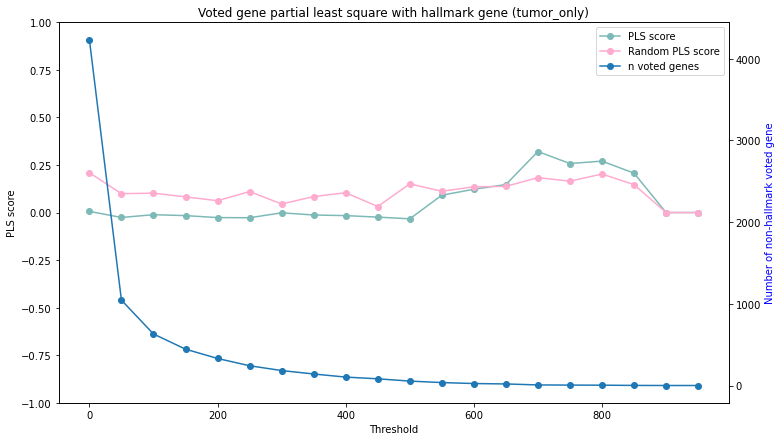

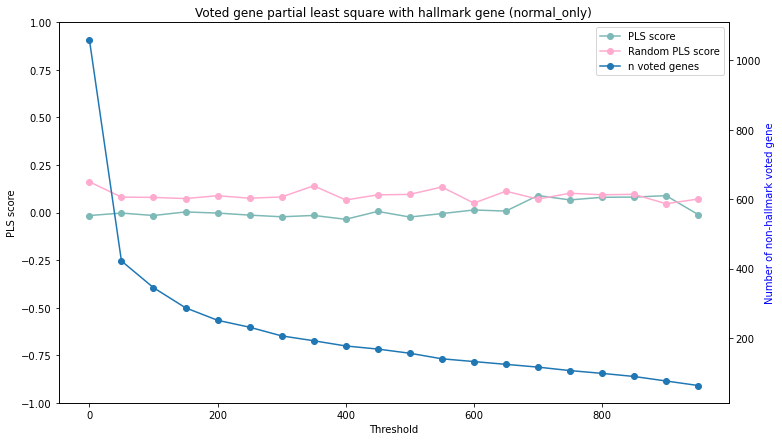

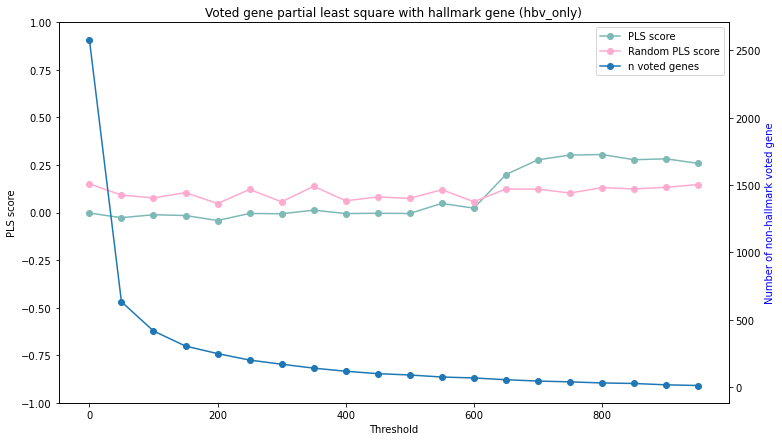

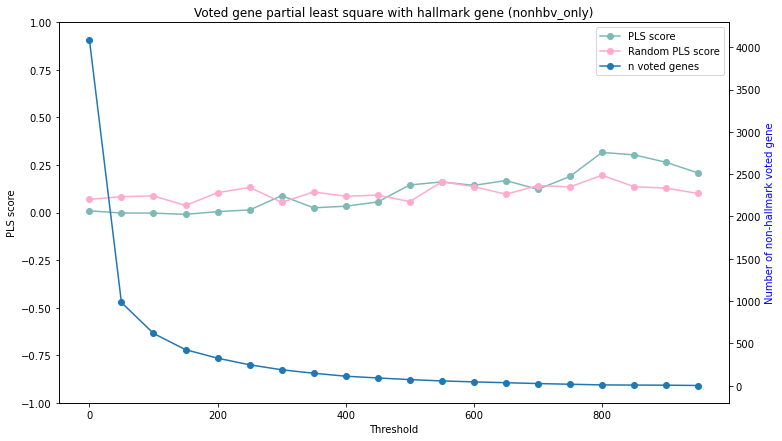

In [35]:
conditions = ['tumor_only','normal_only','hbv_only','nonhbv_only']
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/fig/vote_gene_partial_least_square/'
if os.path.exists(output_path) == False :
    os.mkdir(output_path)

for con in conditions :
    pls_result = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/voted_gene_pls/%s_random_pls_result.txt" % con,sep='\t',index_col=0)
    fig_path = output_path + '%s_pls_2axis_plot.png' % con
    title = "Voted gene partial least square with hallmark gene (%s)" % con
    pls_2axis_plot(pls_result,title,fig_path)